# Spatial Join

Let's explore the concept of creating a spatial join between two geospatial datasets. In an attribute join, two databases can be linked if they both contain a field indexing a common record identifier. In a spatial join, two geospatial features can be linked if they share a specified geospatial relationship. For example, if two features share space or intersect, then attributes of both features can then be linked.

In [1]:
# Load relevant R packages
inLibraries = list('repr','rgeos','rgdal','spdep','classInt','geoR','maptools','sp','raster','RColorBrewer')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
“no DISPLAY variable so Tk is not available”

## US Farming Data

This lab explores county-level data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 US ag. census: https://www.agcensus.usda.gov/Publications/2012/Online_Resources/Ag_Census_Web_Maps/Data_download/index.php. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the excel and/or pdf file).

There is also a field in the ag. census polygons named 'GRIDCODE', which reflects mean annual rainfall between 1990 and 2009 for each county. The original precipitation data was obtained from: https://catalog.data.gov/dataset/united-states-average-annual-precipitation-1990-2009-direct-download. The precipitation data were downloaded in the form of polygons representing areas of similar mean rainfall (i.e. contours) that were likely interpolated from a raster dataset (usagriculture/precip.shp).  A commercial GIS program was then used to spatially join the temp data to the county polygon dataset.


In [2]:
#Read in the county featureclass
inFeatures <- readOGR("datasets/usagriculture","usfarming")

#Read in the temperature featureclass
inPrecip <- readOGR("datasets/usagriculture","precip")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "precip"
with 8174 features
It has 2 fields


In [3]:
head(inFeatures@data)

,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M264_v,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal
0,1,0,01001,Autauga,AUTAUGA,594.437,380439.7,County,001,1,⋯,2.37,Sparse Data,2.37,0.09,Less than 1,0.09,2.96,1 - 2,2.96,NA
1,2,1,01003,Baldwin,BALDWIN,1589.840,1017497.6,County,003,3,⋯,0.63,Sparse Data,0.63,0.04,Less than 1,0.04,4.09,3 - 5,4.09,1
2,2,2,01005,Barbour,BARBOUR,884.876,566320.6,County,005,5,⋯,0.03,Sparse Data,0.03,0.00,Less than 1,0.00,7.68,6 - 8,7.68,NA
3,1,3,01007,Bibb,BIBB,622.583,398453.1,County,007,7,⋯,2.01,Sparse Data,2.01,0.00,Less than 1,0.00,0.86,Less than 1,0.86,NA
4,1,4,01009,Blount,BLOUNT,644.807,412676.5,County,009,9,⋯,-0.21,Sparse Data,-0.21,(D),Less than 1,0.00,0.90,Less than 1,0.90,NA
5,2,5,01011,Bullock,BULLOCK,622.805,398595.2,County,011,11,⋯,1.43,Sparse Data,1.43,(D),Less than 1,0.00,7.24,6 - 8,7.24,NA


In [4]:
head(inPrecip@data)

,ID,GRIDCODE
0,24,80
1,25,80
2,26,70
3,27,70
4,28,25
5,29,20


## Visualize the Precipitation Zones and County Polygons

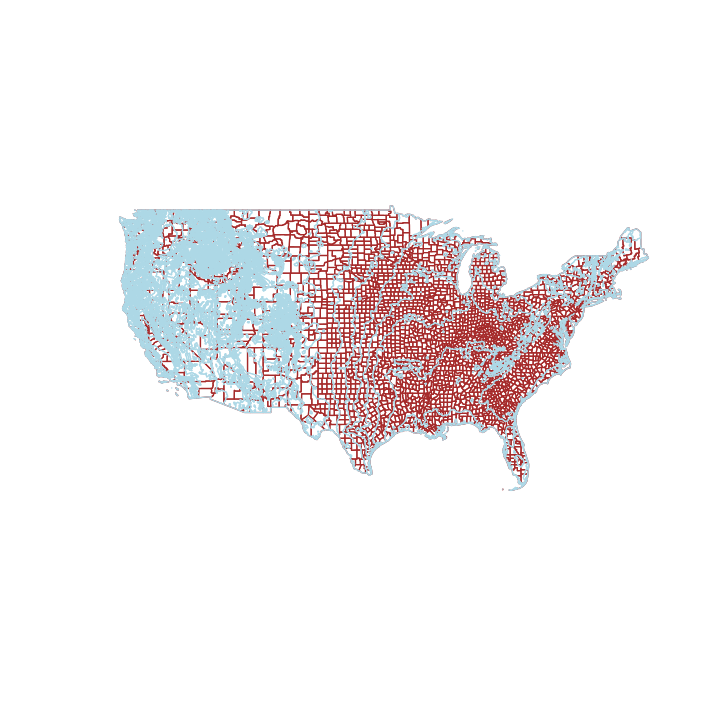

In [5]:
plot(inFeatures, border = 'brown')
plot(inPrecip, add = TRUE, border = "lightblue")

## Subset Features

While it is possible to spatially join these two datasets in their entirety, it's probably not an ideal task to do over a remote server. It would probably be sufficient to conduct the spatial join just for an area of interest which will be the state of California in this lab.

Note, that state names are not explicitly included in the dataset. However, the FIPS code for each county is. Typically, the first two digits of a Fips code reflect the state id number while the last three reflect a specific county within a state.  

For more on fips codes see http://www.nws.noaa.gov/mirs/public/prods/maps/cnty_fips_def.htm. In the code below, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the fips code. Next, grep() is used to select the fips code prefixes which correspond with California ('06').

In [6]:
head(inFeatures@data$atlas_stco)

[1] 01001 01003 01005 01007 01009 01011
3070 Levels: 01001 01003 01005 01007 01009 01011 01013 01015 01017 ... 56045

In [9]:
#add new column to dataframe and populate with first two numbers of fips code
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, start=1, stop=2)

head(inFeatures@data$stcode)

[1] "01" "01" "01" "01" "01" "01"

In [11]:
#select features with a state fips code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

head(inFeaturesSubsetA@data$stcode)

[1] "06" "06" "06" "06" "06" "06"

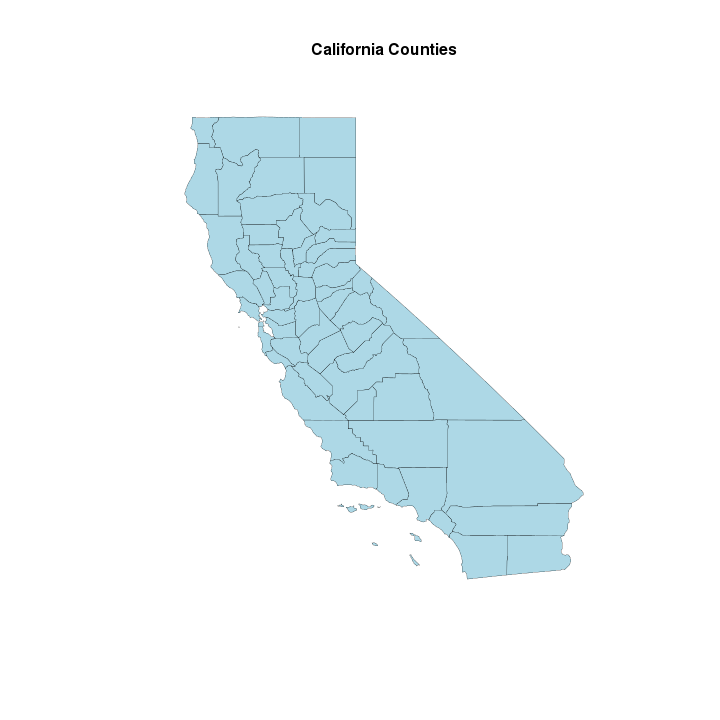

In [12]:
#plot the state selected
plot(inFeaturesSubsetA, col = "lightblue", 
             lwd = 0.2, 
             main = "California Counties", 
             cex.main = 0.8)

## Transform CRS

When attempting any spatial manipulation, it is a good idea to work with a projected CRS. As such, let's transform the data into a CRS more appropriate for California - UTM Zone 10N (epsg=32610).

In [13]:
proj4string(inFeaturesSubsetA)

[1] "+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [14]:
#transform to new CRS
inFeaturesSubsetAUTM <- spTransform(inFeaturesSubsetA, CRS("+init=epsg:32610"))

proj4string(inFeaturesSubsetAUTM)

[1] "+init=epsg:32610 +proj=utm +zone=10 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

In [15]:
proj4string(inPrecip)

[1] "+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [16]:
inPrecipUTM <- spTransform(inPrecip, CRS("+init=epsg:32610"))

proj4string(inPrecipUTM)

[1] "+init=epsg:32610 +proj=utm +zone=10 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

## Repairing Geometry

When a .shp file is imported into any software system, there is no guarantee that the features will be rendered in a topologically correct manner. Thus, it is a good idea to first process the features using a toolkit that understands how to work with geometries...i.e. like the rdgal library. No fancy processes are really necessary to do this, just running any function that requires the data be accessed and transformed in some manner should work. For example, one option is to buffer the features using the gBuffer() function (rgdal library). This function will import the data, buffer the geometries, and then output topologically correct geometries. So, given that we don't want to really change the shape of the features, let's just buffer by a distance of zero!

In [18]:
# buffer county polygons
inFeaturesSubsetAUTMR <- gBuffer(inFeaturesSubsetAUTM, byid = TRUE, width = 0)

# buffer precip areas
inPrecipUTMR <- gBuffer(inPrecipUTM, byid = TRUE, width = 0)

## Geometric Intersection

If one wished to find the geometric intersection of the 3070 county polygons with the 8174 precipitation polygons, they might have to wait awhile... Think about what would happen here...a new polygon will be created anytime a county polygon and a precipitation zone intersect. As such, that means that at minimum zero new features will be created (if no geometric intersection is found), and in cases where intersections exists, a multitude of new polygons may be created. In this example, it is clear that intersections will exist given that both datasets cover the same extent (the continental U.S.). Thus, it can be expected that many new polygons will be created. This is why only California was selected in this example!

There are several libraries for R that contain functions for conducting geometric intersection. The intersect() function (raster library) is probably one of the more straightforward ones to apply. Although we are not working with raster data here, it works perfectly fine with a variety of other spatial dataframes.

Compare the number of input features with the number of intersecting polygons that result. 58 counties intersecting with the temperature polygons result in 1525 new unique intersections!

In [22]:
names(inFeaturesSubsetAUTMR)

[1] "Join_Count" "TARGET_FID" "atlas_stco" "atlas_name" "atlas_caps"
 [6] "atlas_area" "atlas_acre" "entity"     "cntya"      "cntyn"     
[11] "ID"         "GRIDCODE"   "FIPS"       "FIPSTEXT"   "y12_M003_v"
[16] "y12_M003_c" "y12_M003_1" "y12_M079_v" "y12_M079_c" "y12_M079_1"
[21] "y12_M082_v" "y12_M082_c" "y12_M082_1" "y12_M085_v" "y12_M085_c"
[26] "y12_M085_1" "y12_M086_v" "y12_M086_c" "y12_M086_1" "y12_M089_v"
[31] "y12_M089_c" "y12_M089_1" "y12_M090_v" "y12_M090_c" "y12_M090_1"
[36] "y12_M092_v" "y12_M092_c" "y12_M092_1" "y12_M096_v" "y12_M096_c"
[41] "y12_M096_1" "y12_M103_v" "y12_M103_c" "y12_M103_1" "y12_M247_v"
[46] "y12_M247_c" "y12_M247_1" "y12_M249_v" "y12_M249_c" "y12_M249_1"
[51] "y12_M250_v" "y12_M250_c" "y12_M250_1" "y12_M251_v" "y12_M251_c"
[56] "y12_M251_1" "y12_M252_v" "y12_M252_c" "y12_M252_1" "y12_M253_v"
[61] "y12_M253_c" "y12_M253_1" "y12_M254_v" "y12_M254_c" "y12_M254_1"
[66] "y12_M255_v" "y12_M255_c" "y12_M255_1" "y12_M256_v" "y12_M256_c"
[71] "y12_M256_1" "y12_M257_v" "y12_M257_c" "y12_M257_1" "y12_M261_v"
[76] "y12_M261_c" "y12_M261_1" "y12_M262_v" "y12_M262_c" "y12_M262_1"
[81] "y12_M263_v" "y12_M263_c" "y12_M263_1" "y12_M264_v" "y12_M264_c"
[86] "y12_M264_1" "y12_M265_v" "y12_M265_c" "y12_M265_1" "y12_M266_v"
[91] "y12_M266_c" "y12_M266_1" "coastal"    "stcode"

In [23]:
names(inPrecipUTMR)

[1] "ID"       "GRIDCODE"

In [20]:
#Intersect
intPolys <- intersect(inFeaturesSubsetAUTMR, inPrecipUTMR)

names(intPolys)

[1] "Join_Count" "TARGET_FID" "atlas_stco" "atlas_name" "atlas_caps"
 [6] "atlas_area" "atlas_acre" "entity"     "cntya"      "cntyn"     
[11] "ID.1"       "GRIDCODE.1" "FIPS"       "FIPSTEXT"   "y12_M003_v"
[16] "y12_M003_c" "y12_M003_1" "y12_M079_v" "y12_M079_c" "y12_M079_1"
[21] "y12_M082_v" "y12_M082_c" "y12_M082_1" "y12_M085_v" "y12_M085_c"
[26] "y12_M085_1" "y12_M086_v" "y12_M086_c" "y12_M086_1" "y12_M089_v"
[31] "y12_M089_c" "y12_M089_1" "y12_M090_v" "y12_M090_c" "y12_M090_1"
[36] "y12_M092_v" "y12_M092_c" "y12_M092_1" "y12_M096_v" "y12_M096_c"
[41] "y12_M096_1" "y12_M103_v" "y12_M103_c" "y12_M103_1" "y12_M247_v"
[46] "y12_M247_c" "y12_M247_1" "y12_M249_v" "y12_M249_c" "y12_M249_1"
[51] "y12_M250_v" "y12_M250_c" "y12_M250_1" "y12_M251_v" "y12_M251_c"
[56] "y12_M251_1" "y12_M252_v" "y12_M252_c" "y12_M252_1" "y12_M253_v"
[61] "y12_M253_c" "y12_M253_1" "y12_M254_v" "y12_M254_c" "y12_M254_1"
[66] "y12_M255_v" "y12_M255_c" "y12_M255_1" "y12_M256_v" "y12_M256_c"
[71] "y12_M256_1" "y12_M257_v" "y12_M257_c" "y12_M257_1" "y12_M261_v"
[76] "y12_M261_c" "y12_M261_1" "y12_M262_v" "y12_M262_c" "y12_M262_1"
[81] "y12_M263_v" "y12_M263_c" "y12_M263_1" "y12_M264_v" "y12_M264_c"
[86] "y12_M264_1" "y12_M265_v" "y12_M265_c" "y12_M265_1" "y12_M266_v"
[91] "y12_M266_c" "y12_M266_1" "coastal"    "stcode"     "ID.2"      
[96] "GRIDCODE.2"

In [25]:
#check how many input counties were considered
length(inFeaturesSubsetAUTMR)

[1] 58

In [26]:
#check how many input precip areas were considered
length(inPrecipUTMR)

[1] 8174

In [27]:
#check how many output polygons resulted from this operation
length(intPolys)

[1] 1525

## Aggregate

Now that many smaller areal units have been created by the intersect procedure, they need to be put back together again so that they represent the entire county polygons. In cases where a single precipitation zone covers an entire county, no problem (one to one correspondence). In cases where multiple precipitation zones cover a county, then we need to decide how they will be merged. For instance, if 4 different precipitation zones cover a county with mean precipitation of 84, 89, 85, and 88 inches, what should be the final rainfall that is associated with the county?  Should it be the average, the minimum (84), the maximum(89), etc? Well, this decision is actually up to you! In this example, we'll compute the mean precipitation, but will weight the contribution to the county's overally precipitation by the size of the the precipitation zones covering the county...i.e. proportional to the amount of the county within a particular precipitation zones. The aggregate() function (sp library) is used to accomplish this. Finally, the merge() function can be used to couple the two dataframes.

In [29]:
#aggregate intersected polygons based on the name of the county
#get name of county
uniqueid <- intPolys$atlas_name


head(uniqueid)

[1] Alameda Alameda Alameda Alameda Alameda Alameda
1777 Levels: Abbeville Acadia Accomack Ada Adair Adams Addison Aiken ... Ziebach

In [30]:
#aggregate data
poly.df <- as(intPolys, "data.frame")

head(poly.df)

Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,ID.2,GRIDCODE.2
7,157,06001,Alameda,ALAMEDA,739.022,472974.1,County,001,1,⋯,0.80,Less than 1,0.8,0.09,Less than 1,0.09,1,06,7021,30
7,157,06001,Alameda,ALAMEDA,739.022,472974.1,County,001,1,⋯,0.80,Less than 1,0.8,0.09,Less than 1,0.09,1,06,7057,15
7,157,06001,Alameda,ALAMEDA,739.022,472974.1,County,001,1,⋯,0.80,Less than 1,0.8,0.09,Less than 1,0.09,1,06,7234,20
7,157,06001,Alameda,ALAMEDA,739.022,472974.1,County,001,1,⋯,0.80,Less than 1,0.8,0.09,Less than 1,0.09,1,06,7265,25
7,157,06001,Alameda,ALAMEDA,739.022,472974.1,County,001,1,⋯,0.80,Less than 1,0.8,0.09,Less than 1,0.09,1,06,7355,25
7,157,06001,Alameda,ALAMEDA,739.022,472974.1,County,001,1,⋯,0.80,Less than 1,0.8,0.09,Less than 1,0.09,1,06,7373,20


In [32]:
numcols <- ncol(poly.df)

numcols

[1] 96

In [44]:
lastCol <- poly.df[ , (numcols - 1) : numcols]

head(lastCol)

ID.2,GRIDCODE.2
7021,30
7057,15
7234,20
7265,25
7355,25
7373,20


In [45]:
#NOTE: poly.df[,(numcols-1):numcols] retrieves the last column of the dataframe, the one = GRIDCODE.2

CC <- aggregate(lastCol, by = list(uniqueid),
               FUN = mean, dissolve = TRUE, areaWeighted = TRUE)

head(CC)

Group.1,ID.2,GRIDCODE.2
Alameda,7305.143,21.42857
Alpine,6761.474,35.52632
Amador,6937.667,40.00000
Butte,6170.133,56.16667
Calaveras,6943.167,36.11111
Colusa,6541.000,37.50000


In [47]:
# merge the county dataframe with the aggregated precip data
inFeaturesSubsetJoined <- merge(x = inFeaturesSubsetAUTMR@data, 
                                        y = CC, 
                                        by.x = "atlas_name", 
                                        by.y = "Group.1", 
                                        all = TRUE)

head(inFeaturesSubsetJoined)

# Here is how to reconstruct the county polygons if desired vs using the existing county polygons and then merging
# geometric union based on county name
# poly.union <- unionSpatialPolygons(intPolys, uniqueid)
# row.names(CC) <- as.character(CC$Group.1)
# inFeaturesSubsetJoined <- SpatialPolygonsDataFrame(poly.union, CC)

atlas_name,Join_Count,TARGET_FID,atlas_stco,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,ID.2,GRIDCODE.2
Alameda,7,157,06001,ALAMEDA,739.022,472974.1,County,001,1,⋯,0.80,Less than 1,0.80,0.09,Less than 1,0.09,1,06,7305.143,21.42857
Alpine,19,158,06003,ALPINE,738.319,472524.2,County,003,3,⋯,(D),10 - 14,0.00,(D),Less than 1,0.00,NA,06,6761.474,35.52632
Amador,9,159,06005,AMADOR,594.577,380529.3,County,005,5,⋯,3.49,1 - 4,3.49,(D),Less than 1,0.00,NA,06,6937.667,40.00000
Butte,30,160,06007,BUTTE,1636.464,1047337.0,County,007,7,⋯,4.72,1 - 4,4.72,0.13,Less than 1,0.13,NA,06,6170.133,56.16667
Calaveras,18,161,06009,CALAVERAS,1020.013,652808.3,County,009,9,⋯,1.09,1 - 4,1.09,(D),Less than 1,0.00,NA,06,6943.167,36.11111
Colusa,10,162,06011,COLUSA,1150.728,736465.9,County,011,11,⋯,5.73,5 - 9,5.73,0.64,Less than 1,0.64,NA,06,6541.000,37.50000


### Plot the Joined Attribute

Plot the spatially joined precipitation attribute 'GRIDCODE.2'. You can try and compare these values with the attribute 'GRIDCODE' that was created using a spatial join in a commercial GIS. The values are pretty close but are not exactly the same in most cases. Why? Slightly different merge criteria were used to merge the precipitation data.

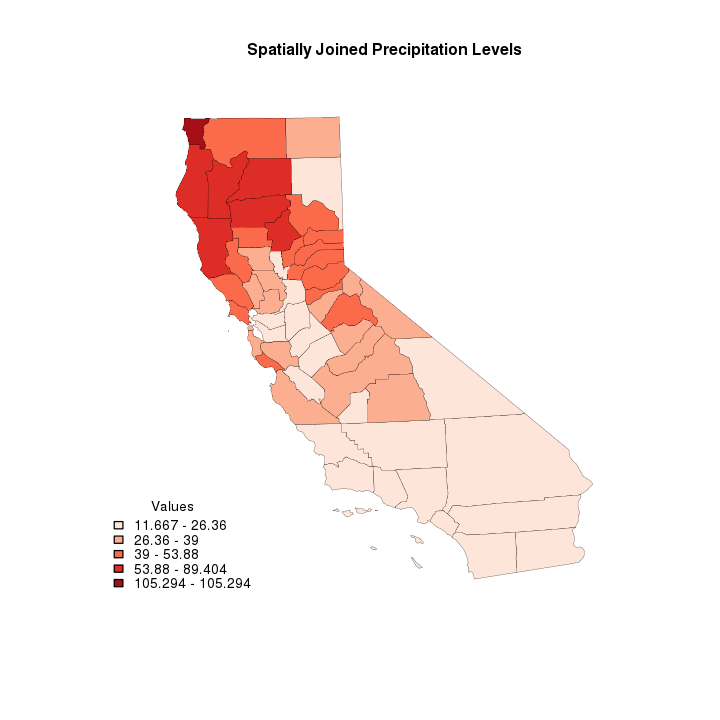

In [48]:
numcat <- 5
pal <- brewer.pal(numcat,"Reds")
q <- classIntervals(inFeaturesSubsetJoined$GRIDCODE.2, numcat, style="kmeans")
cols <- findColours(q,pal)

plot(inFeaturesSubsetAUTMR, col = cols, lwd=.2, main ="Spatially Joined Precipitation Levels",cex.main=.8)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Values",cex=.7)